In [33]:
import os

import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

cv_dataset = torchaudio.datasets.COMMONVOICE(
    root="_cv_corpus/en",
    tsv="test.tsv"
)

TEST_NUM = 4

cv_dataset[TEST_NUM]

1.13.0.dev20220725
0.13.0.dev20220725
cpu


(tensor([[ 0.0000e+00,  3.2264e-12,  9.5456e-13,  ..., -3.9585e-05,
          -4.8796e-05, -5.5674e-05]]),
 32000,
 {'client_id': '001519f234e04528a2b36158c205dbe61c8da45ab0242f8800d6c4c2e9ac6ca76c9e5af86a313ab309f426c44204dfa7d2bb14b37ed565af9c1c6c86943675f9',
  'path': 'common_voice_en_27340672.mp3',
  'sentence': 'It is a busy market town that serves a large surrounding area.',
  'up_votes': '2',
  'down_votes': '0',
  'age': '',
  'gender': '',
  'accents': '',
  'locale': 'en',
  'segment': ''})

In [34]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [35]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [39]:
waveform, sample_rate, metadata = cv_dataset[TEST_NUM]
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [40]:
with torch.inference_mode():
    emission, _ = model(waveform)

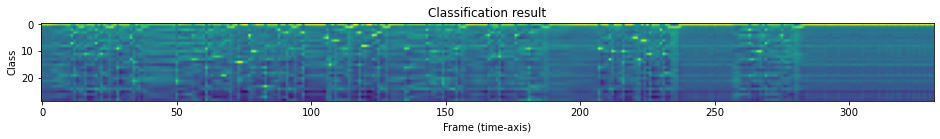

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [41]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [44]:
from torchaudio.models.decoder import ctc_decoder
from torchaudio.models.decoder import download_pretrained_files

files = download_pretrained_files("librispeech-4-gram")

print(files)

LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

PretrainedFiles(lexicon='/Users/LEllison/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/Users/LEllison/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/Users/LEllison/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')


In [45]:
transcript = beam_search_decoder(emission[0][None, :])
print(transcript)
print(metadata['sentence'])

[[CTCHypothesis(tokens=tensor([ 1,  7,  3,  1,  7,  9,  1,  4,  1, 21, 13,  9, 19,  1, 14,  4, 10, 23,
         2,  3,  1,  3,  5, 15,  6,  1,  3,  8,  4,  3,  1,  9,  2, 10, 22,  2,
        11,  1,  4,  3,  1, 12,  4,  9,  3,  1,  9, 13, 10, 10,  5, 13,  6, 11,
         2, 11,  1,  4, 10,  2,  4,  1,  1]), words=['it', 'is', 'a', 'busy', 'market', 'town', 'that', 'served', 'at', 'last', 'surrounded', 'area'], score=3469.2922987014053, timesteps=tensor([  0,  12,  13,  15,  21,  23,  25,  34,  39,  51,  57,  62,  68,  70,
         74,  78,  79,  84,  89,  92,  95,  98, 107, 108, 110, 114, 119, 120,
        124, 126, 128, 136, 144, 147, 150, 152, 155, 157, 167, 168, 170, 171,
        177, 182, 183, 187, 208, 212, 213, 217, 221, 223, 224, 227, 231, 232,
        234, 264, 267, 270, 276, 280, 333], dtype=torch.int32)), CTCHypothesis(tokens=tensor([ 1,  7,  3,  1,  7,  9,  1,  4,  1, 21, 13,  9, 19,  1, 14,  4, 10, 23,
         2,  3,  1,  3,  5, 15,  6,  1,  3,  8,  4,  3,  1,  9,  2, 10, 